# Pre Test set

x is 224 and y is 224 and z is 11
(50176, 11)


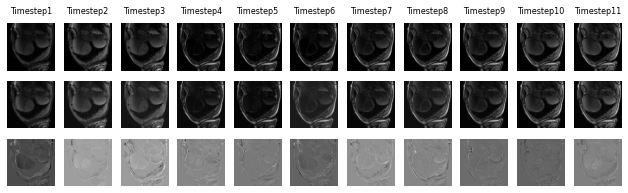

In [3]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from hyperspy.learn.rpca import rpca_godec, orpca
path = 'data/MOLLI_pre_dataset/test/0387056_20140423_MOLLI_3.npy'
vols = np.load(path).transpose(1, 2, 0)
x, y, z = vols.shape
print(f"x is {x} and y is {y} and z is {z}")
M = vols.reshape(x*y, z)
print(M.shape)
low, sparse, U, S, V = rpca_godec(M, rank=5)
low_matrix = low.reshape((x, y, z))
sparse_matrix = sparse.reshape((x, y, z))

fig = plt.figure(figsize=(11, 3))
title_font_size=8
title_pad = 10
for i in range(z):
    ax1 = fig.add_subplot(3, 11, 1+i)
    plt.imshow(vols[..., i], cmap='gray')
    plt.axis('off')
    ax1.set_title(f"Timestep{i+1}", fontsize=title_font_size, pad=title_pad)

    ax2 = fig.add_subplot(3, 11, 12+i)
    plt.imshow(low_matrix[..., i], cmap='gray')
    plt.axis('off')

    ax3 = fig.add_subplot(3, 11, 23+i)
    plt.imshow(sparse_matrix[..., i], cmap='gray')
    plt.axis('off')

## Test Metrics

### Original volume

#### First Eigen Component percentage

In [10]:
from scripts.utils import *
orig_path = 'data/MOLLI_pre_dataset/test'
orig_pca_changes = []
for file in sorted(glob.glob(os.path.join(orig_path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    orig_pca_changes.append(org_dis)
print(f"Mean of original PCA is {np.mean(np.array(orig_pca_changes))}")

Mean of original PCA is 0.7867720274668718


#### T1 fitting

Mean of t1err is 11.072921129848977 and std is 4.963850319538608
Mean of t1err is 14.217012343355398 and std is 7.345939012337131


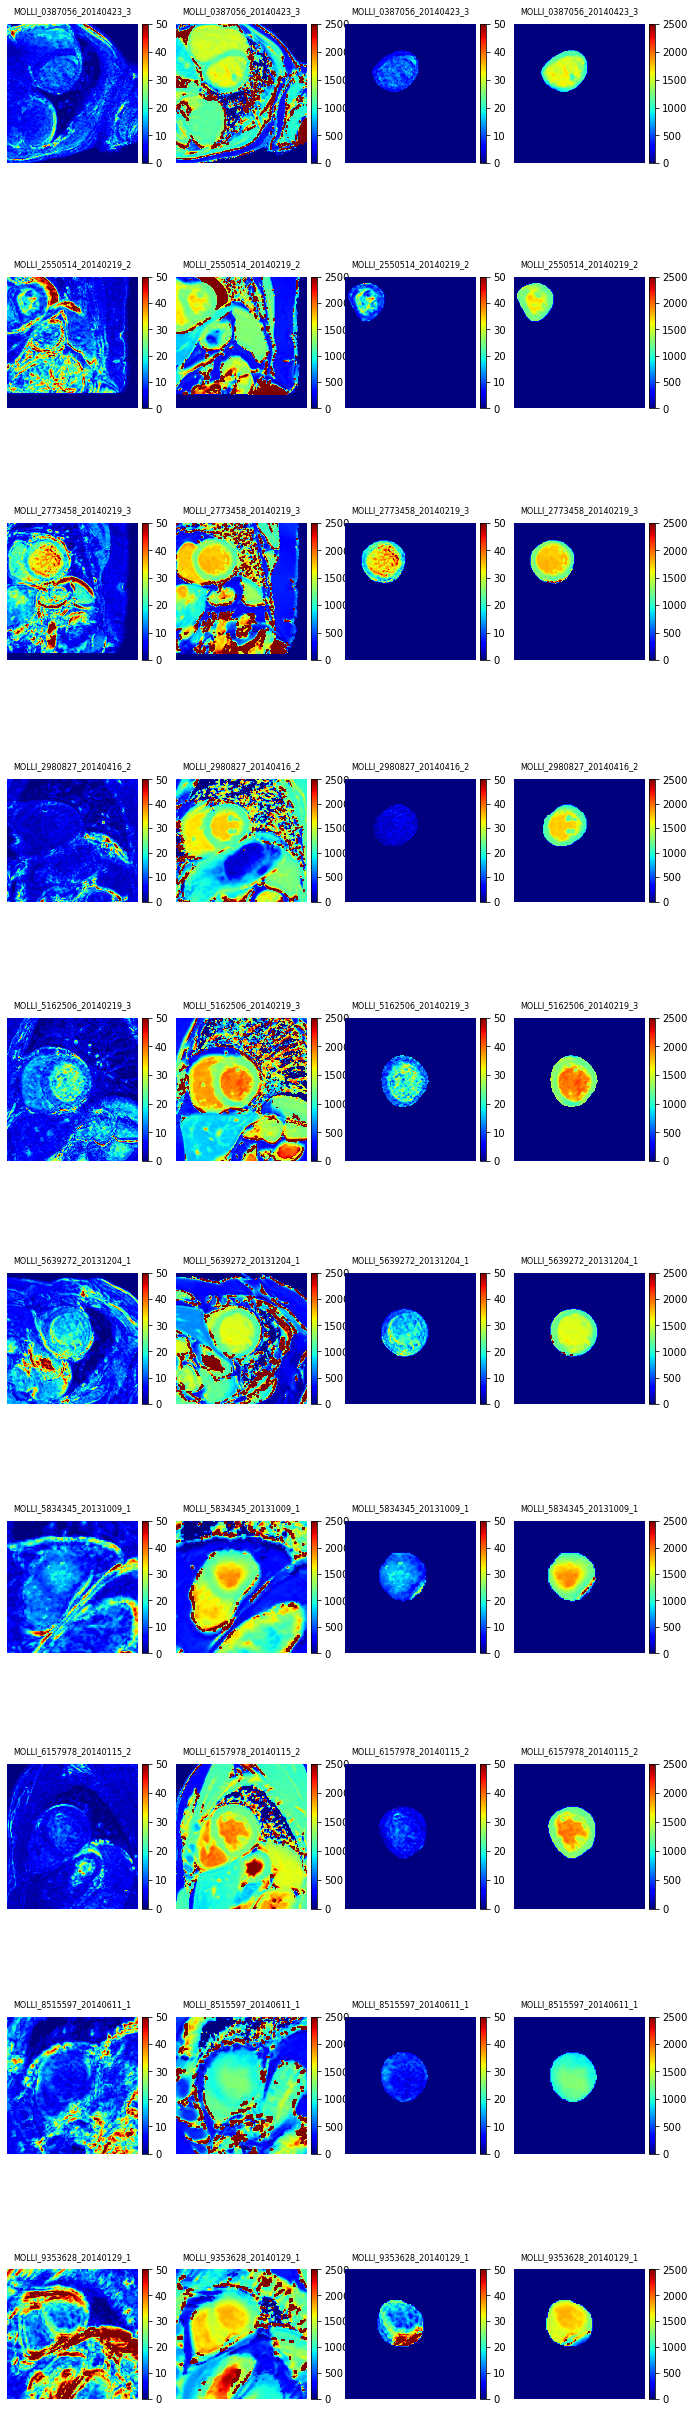

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
path = "data/MOLLI_pre_dataset/T1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
orig_t1err_square_list = []
orig_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    itemindex = np.where(areamask == 1)
    x1, x2 = itemindex[0][0], itemindex[0][-1]
    y1, y2 = itemindex[1][0], itemindex[1][-1]
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    orig_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    orig_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(orig_t1err_square_list))} and std is {np.std(np.array(orig_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(orig_t1err_heart_list))} and std is {np.std(np.array(orig_t1err_heart_list))}")
plt.savefig(f"data/MOLLI_pre_dataset/T1_SDerr/orig_t1err.png", dpi=300)

### Round 1

In [12]:
import voxelmorph_group as vxm  # nopep8
import numpy as np
import glob
import os
jacobian = vxm.losses.Jacobian().loss

In [13]:
r = 1
root = f"results/MOLLI_pre/group/rank_10_5_3/tc/smooth/image_loss_weight1/cycle_loss_weight0.01/weight0.001/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre"
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [14]:
path = f"{base_path}/moved"
r1_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r1_pca_changes.append(org_dis)
print(f"Mean of Round 1 PCA is {np.mean(np.array(r1_pca_changes))} and std is {np.std(np.array(r1_pca_changes))}")

Mean of Round 1 PCA is 0.793857685935114 and std is 0.02388205729546182


#### Jacobian Determination

In [15]:
r1_folding_ratio_list = []
r1_mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r1_folding_ratio_list.append(folding_ratio)
    r1_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r1_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r1_mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.001919481554068625


#### T1 fitting

Mean of t1err is 10.093839342773894 and std is 4.4722711227728125
Mean of t1err is 13.789299164314329 and std is 7.037638671809291


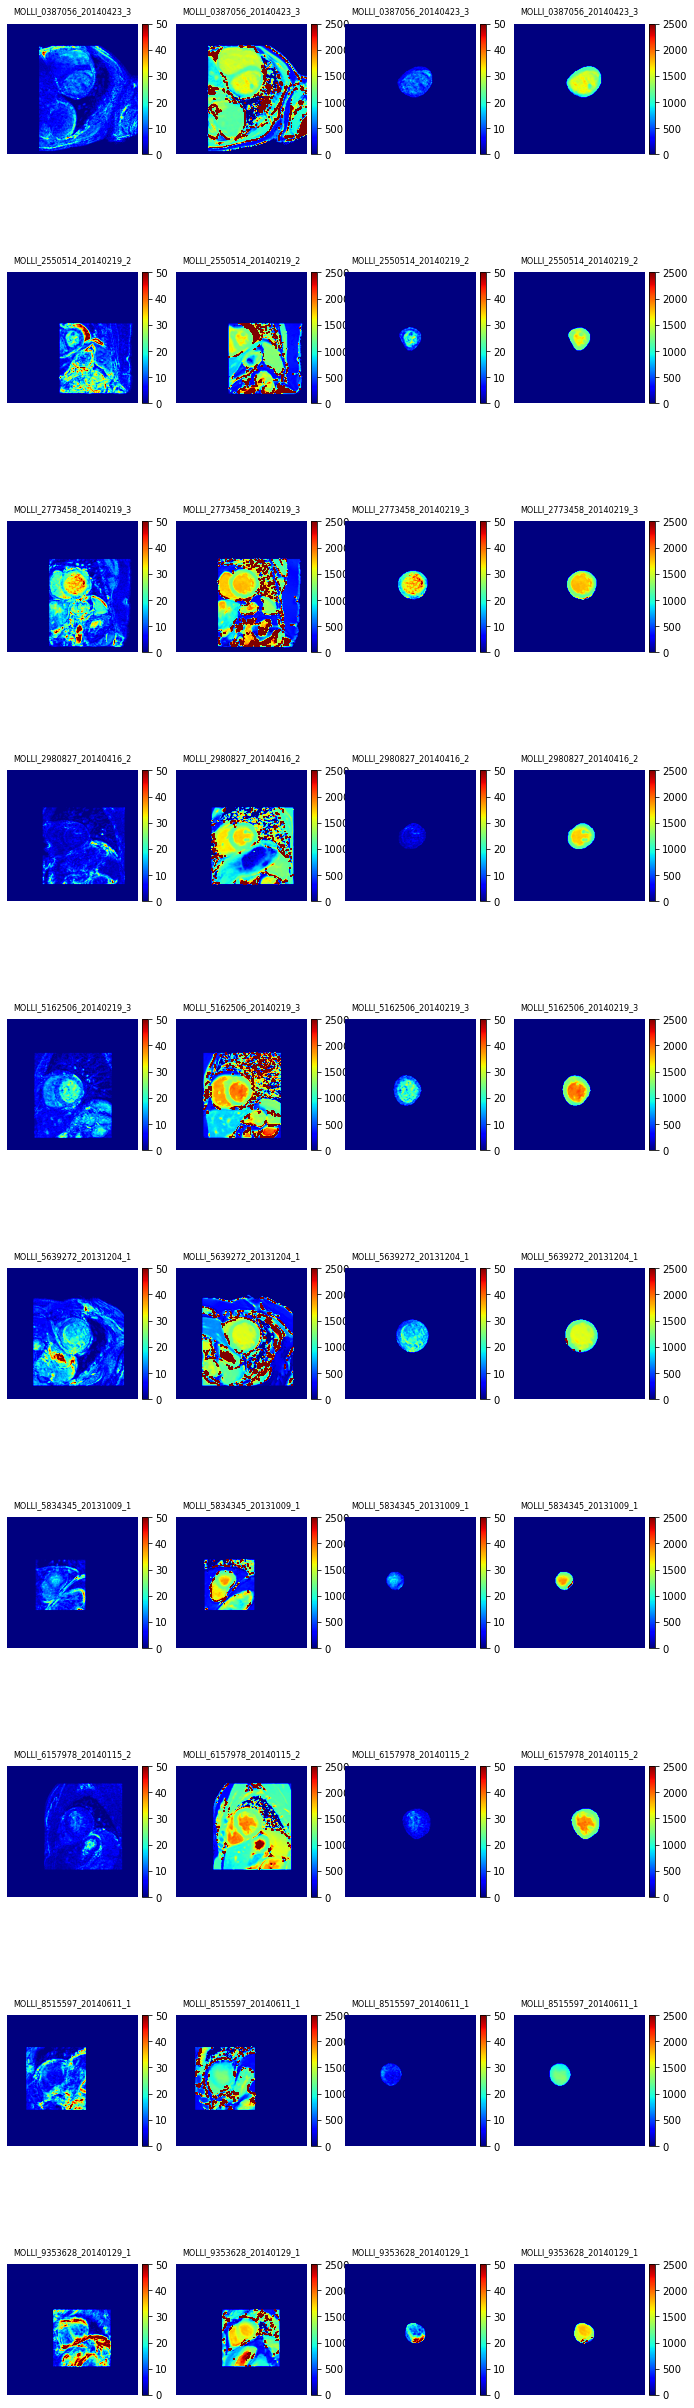

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
path = f"{base_path}/t1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
r1_t1err_square_list = []
r1_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    itemindex = np.where(areamask == 1)
    x1, x2 = itemindex[0][0], itemindex[0][-1]
    y1, y2 = itemindex[1][0], itemindex[1][-1]
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    orig_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    orig_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(r1_t1err_square_list))} and std is {np.std(np.array(r1_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(r1_t1err_heart_list))} and std is {np.std(np.array(r1_t1err_heart_list))}")
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

### Round 2

In [17]:
r = 2
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [18]:
path = f"{base_path}/moved"
r2_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r2_pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(r2_pca_changes))} and std is {np.std(np.array(r2_pca_changes))}")

Mean of Round 2 PCA is 0.7976837193947512 and std is 0.0239574913177589


#### Jacobian Determination

In [19]:
r2_folding_ratio_list = []
r2_mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r2_folding_ratio_list.append(folding_ratio)
    r2_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r2_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r2_mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0014214934781193733


#### T1 fitting

Mean of t1err is 9.962366532333249 and std is 4.347926428557493
Mean of t1err is 13.666033146177474 and std is 6.942911336134126


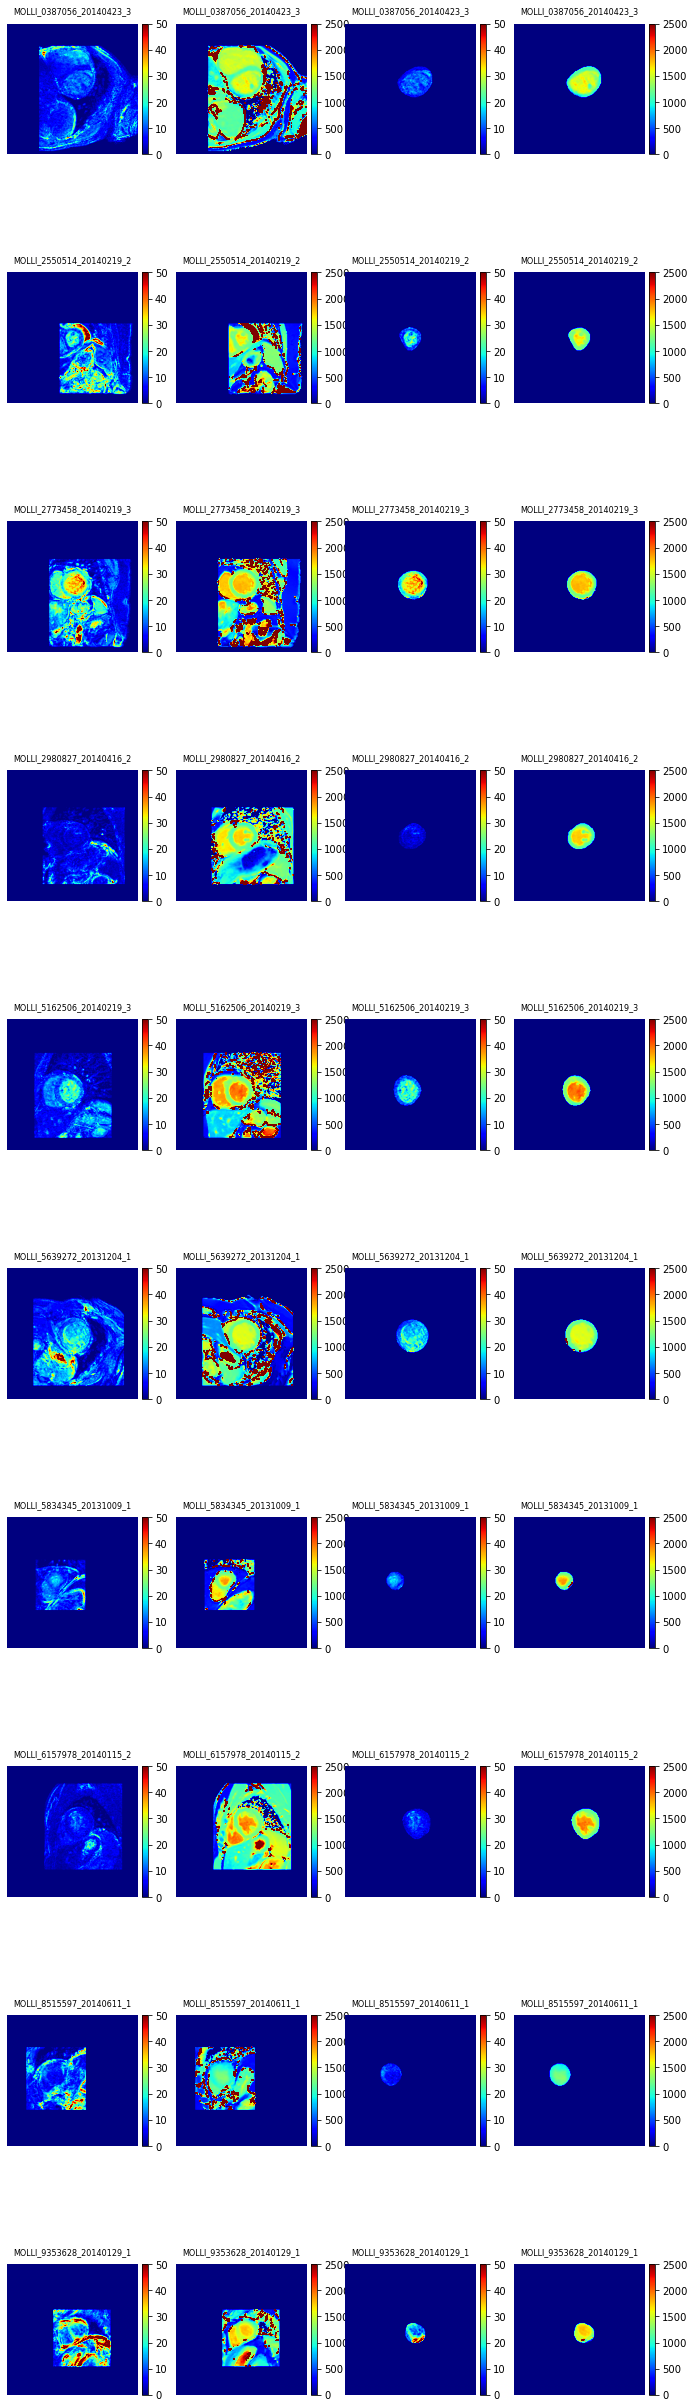

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
path = f"{base_path}/t1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
r2_t1err_square_list = []
r2_t1err_heart_list = []
subject_list = []

for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    itemindex = np.where(areamask == 1)
    x1, x2 = itemindex[0][0], itemindex[0][-1]
    y1, y2 = itemindex[1][0], itemindex[1][-1]
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    orig_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    orig_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(r2_t1err_square_list))} and std is {np.std(np.array(r2_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(r2_t1err_heart_list))} and std is {np.std(np.array(r2_t1err_heart_list))}")
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

### Round 3

In [21]:
r = 3
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [22]:
path = f"{base_path}/moved"
r3_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r3_pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(r3_pca_changes))} and std is {np.std(np.array(r3_pca_changes))}")

Mean of Round 2 PCA is 0.8012026210147243 and std is 0.02408318704937137


#### Jacobian Determination

In [23]:
r3_folding_ratio_list = []
r3_mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r3_folding_ratio_list.append(folding_ratio)
    r3_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r3_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r3_mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0014855830231681466


#### T1 fitting

Mean of t1err is 9.869672460057501 and std is 4.2479970826963775
Mean of t1err is 13.546738800413717 and std is 6.841494485140922


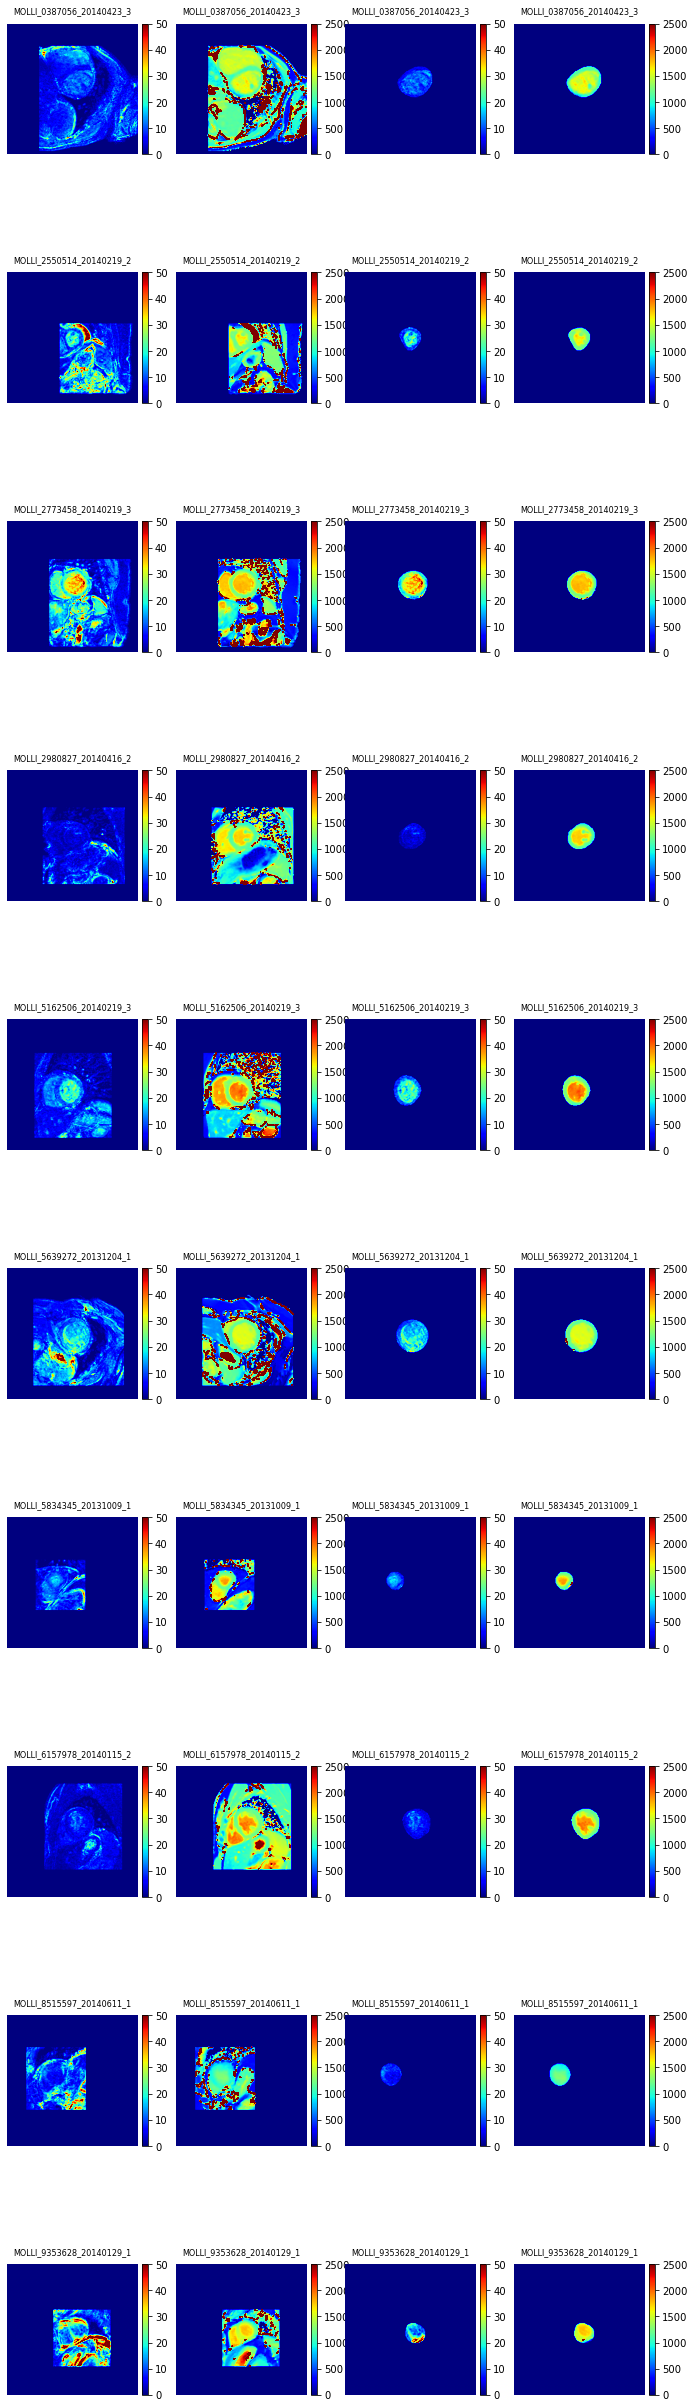

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget

path = f"{base_path}/t1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
r3_t1err_square_list = []
r3_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    itemindex = np.where(areamask == 1)
    x1, x2 = itemindex[0][0], itemindex[0][-1]
    y1, y2 = itemindex[1][0], itemindex[1][-1]
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    orig_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    orig_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(r3_t1err_square_list))} and std is {np.std(np.array(r3_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(r3_t1err_heart_list))} and std is {np.std(np.array(r3_t1err_heart_list))}")
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

### Summary

In [25]:
import pandas as pd
df = pd.DataFrame()
df['Cases'] = subject_list
df['Raw Square T1err'] = orig_t1err_square_list
df['R1 Square T1err'] = r1_t1err_square_list
df['R2 Square T1err'] = r2_t1err_square_list
df['R3 Square T1err'] = r3_t1err_square_list
df['Square T1err diff'] = (df['Raw Square T1err'] - df['R3 Square T1err']) / df['Raw Square T1err']
df['Raw Heart T1err'] = orig_t1err_heart_list
df['R1 Heart T1err'] = r1_t1err_heart_list
df['R2 Heart T1err'] = r2_t1err_heart_list
df['R3 Heart T1err'] = r3_t1err_heart_list
df['Heart T1err diff'] = (df['Raw Heart T1err'] - df['R3 Heart T1err']) / df['Raw Heart T1err']
df

,Cases,Raw Square T1err,R1 Square T1err,R2 Square T1err,R3 Square T1err,Square T1err diff,Raw Heart T1err,R1 Heart T1err,R2 Heart T1err,R3 Heart T1err,Heart T1err diff
0,MOLLI_0387056_20140423_3,7.539072,7.130918,7.084625,7.027026,0.067919,9.731935,9.720822,9.705940,9.610726,0.012455
1,MOLLI_2550514_20140219_2,12.360840,11.807148,11.632607,11.516364,0.068319,14.576425,14.161064,14.091633,14.061569,0.035321
2,MOLLI_2773458_20140219_3,13.635501,12.172929,12.119013,12.073634,0.114544,28.671655,28.187993,28.276511,28.218837,0.015793
3,MOLLI_2980827_20140416_2,5.785524,5.249260,5.172836,5.110092,0.116745,3.958349,4.166053,4.221649,4.199056,-0.060810
4,MOLLI_5162506_20140219_3,8.644283,7.944118,7.822767,7.756971,0.102647,17.141349,16.596108,16.360403,16.343261,0.046559
5,MOLLI_5639272_20131204_1,11.297461,10.362253,10.300761,10.313012,0.087139,17.010539,16.474280,16.343546,16.326520,0.040211
6,MOLLI_5834345_20131009_1,10.555566,8.907581,8.813704,8.750942,0.170964,12.637421,11.743045,11.649457,11.632515,0.079518
7,MOLLI_6157978_20140115_2,5.011841,4.668174,4.662830,4.684098,0.065394,6.933013,6.883942,6.916135,6.914891,0.002614
8,MOLLI_8515597_20140611_1,12.463286,11.513880,11.359444,11.226235,0.099256,7.736930,7.601820,7.550966,7.526708,0.027171
9,MOLLI_9353628_20140129_1,23.435838,21.182134,20.655078,20.238349,0.136436,23.772507,22.357864,21.544090,20.633306,0.132052


In [26]:
df.describe()

,Raw Square T1err,R1 Square T1err,R2 Square T1err,R3 Square T1err,Square T1err diff,Raw Heart T1err,R1 Heart T1err,R2 Heart T1err,R3 Heart T1err,Heart T1err diff
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,11.072921,10.093839,9.962367,9.869672,0.102936,14.217012,13.789299,13.666033,13.546739,0.033089
std,5.232358,4.714188,4.583117,4.477782,0.033620,7.743300,7.418323,7.318471,7.211568,0.050213
min,5.011841,4.668174,4.662830,4.684098,0.065394,3.958349,4.166053,4.221649,4.199056,-0.060810
25%,7.815375,7.334218,7.269161,7.209512,0.073024,8.235682,8.131571,8.089709,8.047713,0.013289
50%,10.926513,9.634917,9.557233,9.531977,0.100951,13.606923,12.952055,12.870545,12.847042,0.031246
75%,12.437674,11.733831,11.564316,11.443832,0.116195,17.108646,16.565651,16.356189,16.339076,0.044972
max,23.435838,21.182134,20.655078,20.238349,0.170964,28.671655,28.187993,28.276511,28.218837,0.132052


In [27]:
df_2 = pd.DataFrame()
df_2['Cases'] = subject_list
df_2['Raw PCA'] = orig_pca_changes
df_2['R1 PCA'] = r1_pca_changes
df_2['R2 PCA'] = r2_pca_changes
df_2['R3 PCA'] = r3_pca_changes
df_2['R1 Det'] = r1_mag_det_jac_det_list
df_2['R2 Det'] = r2_mag_det_jac_det_list
df_2['R3 Det'] = r3_mag_det_jac_det_list
df_2['R1 Fold ratio'] = r1_folding_ratio_list
df_2['R2 Fold ratio'] = r2_folding_ratio_list
df_2['R3 Fold ratio'] = r3_folding_ratio_list
df_2

,Cases,Raw PCA,R1 PCA,R2 PCA,R3 PCA,R1 Det,R2 Det,R3 Det,R1 Fold ratio,R2 Fold ratio,R3 Fold ratio
0,MOLLI_0387056_20140423_3,0.806249,0.813078,0.814879,0.815738,0.001454,0.000928,0.000622,0.0,0.0,0.0
1,MOLLI_2550514_20140219_2,0.792254,0.798774,0.803869,0.807555,0.001882,0.001505,0.001499,0.0,0.0,0.0
2,MOLLI_2773458_20140219_3,0.773361,0.780556,0.784168,0.787251,0.001849,0.001480,0.001538,0.0,0.0,0.0
3,MOLLI_2980827_20140416_2,0.813012,0.817918,0.822025,0.825961,0.001816,0.001487,0.001457,0.0,0.0,0.0
4,MOLLI_5162506_20140219_3,0.787799,0.791948,0.795104,0.798467,0.001889,0.001480,0.001638,0.0,0.0,0.0
5,MOLLI_5639272_20131204_1,0.773060,0.778741,0.781976,0.785015,0.001856,0.001463,0.001446,0.0,0.0,0.0
6,MOLLI_5834345_20131009_1,0.757565,0.767065,0.771976,0.776596,0.002230,0.001434,0.001797,0.0,0.0,0.0
7,MOLLI_6157978_20140115_2,0.839774,0.844987,0.849815,0.854893,0.001675,0.001410,0.001331,0.0,0.0,0.0
8,MOLLI_8515597_20140611_1,0.770515,0.779798,0.783658,0.787595,0.002349,0.001593,0.001752,0.0,0.0,0.0
9,MOLLI_9353628_20140129_1,0.754133,0.765712,0.769368,0.772956,0.002195,0.001435,0.001774,0.0,0.0,0.0


In [28]:
df_2.describe()

,Raw PCA,R1 PCA,R2 PCA,R3 PCA,R1 Det,R2 Det,R3 Det,R1 Fold ratio,R2 Fold ratio,R3 Fold ratio
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0
mean,0.786772,0.793858,0.797684,0.801203,0.001919,0.001421,0.001486,0.0,0.0,0.0
std,0.026789,0.025174,0.025253,0.025386,0.000270,0.000181,0.000342,0.0,0.0,0.0
min,0.754133,0.765712,0.769368,0.772956,0.001454,0.000928,0.000622,0.0,0.0,0.0
25%,0.771151,0.779005,0.782396,0.785574,0.001824,0.001434,0.001449,0.0,0.0,0.0
50%,0.780580,0.786252,0.789636,0.793031,0.001869,0.001471,0.001519,0.0,0.0,0.0
75%,0.802750,0.809502,0.812127,0.813692,0.002118,0.001485,0.001724,0.0,0.0,0.0
max,0.839774,0.844987,0.849815,0.854893,0.002349,0.001593,0.001797,0.0,0.0,0.0


In [29]:
df_2.describe()

,Raw PCA,R1 PCA,R2 PCA,R3 PCA,R1 Det,R2 Det,R3 Det,R1 Fold ratio,R2 Fold ratio,R3 Fold ratio
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0
mean,0.786772,0.793858,0.797684,0.801203,0.001919,0.001421,0.001486,0.0,0.0,0.0
std,0.026789,0.025174,0.025253,0.025386,0.000270,0.000181,0.000342,0.0,0.0,0.0
min,0.754133,0.765712,0.769368,0.772956,0.001454,0.000928,0.000622,0.0,0.0,0.0
25%,0.771151,0.779005,0.782396,0.785574,0.001824,0.001434,0.001449,0.0,0.0,0.0
50%,0.780580,0.786252,0.789636,0.793031,0.001869,0.001471,0.001519,0.0,0.0,0.0
75%,0.802750,0.809502,0.812127,0.813692,0.002118,0.001485,0.001724,0.0,0.0,0.0
max,0.839774,0.844987,0.849815,0.854893,0.002349,0.001593,0.001797,0.0,0.0,0.0
